# Project 9: Chess
### Name: Matthew Yao

During Project 6 I made several requests to Chess.com and visualized my results. There was a *lot* of data I could use, so I decided to analyze it further for this project.

This time, instead of analyzing the ratings of grandmasters, I wanted to analyze my own games to see how I could improve. Thus, my analysis focused on answering several primary questions:

- What's my Win/Loss/Draw rate?
- What's my Wins by Color rate?
- What area of my game do I struggle with the most (opening, middlegame, endgame, where do I lose)?
- What is my accuracy against different levels of opponents?
- What is the correlation between my win rate and my accuracy? Rating? Opponent accuracy? Black/White?

I also wanted to learn about other questions, such as:

- What day did I play the most games?
- What day did I win the most games?
- What day did I lose the most games?
- What country do I play the most games against?

I didn't choose to analyze different openings for three reasons: I usually stick to the same openings, I was unsure how to efficiently get rating information, and, mainly, I don't know enough about openings to analyze them.

Suprisingly, Chess.com doesn't have a personal data request feature, so I had to resort to scraping my own data using Selenium and BeautifulSoup.

In [2]:
# nothing much here, just a bunch of imports and an environmental password variable so you can't steal my chess.com account

import pandas as pd
import numpy as np
import bs4
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from datetime import datetime
import random
import time
import hashlib
import os
import dotenv
import matplotlib.pyplot as plt

dotenv.load_dotenv()
password = os.getenv("PASSWORD")

One thing that I quickly realized is that there is no consistent or simple way to get any game data from the public API. All of the data I needed was available, but it was scattered across several different endpoints. I decided to use Selenium to scrape the data directly from the website. We didn't use Selenium in class, but I had used it before in personal projects, and I choose to use it instead of BeautifulSoup because I needed to interact with the website itself.

One of the first issues I had was that game accuracy was not automatically calculated and displayed. It had to be manually calculated for each game by clicking on the "Analyze" button. I wrote this quick script to click the button for each game so that I could use accuracy data.

I found a chess.com fourm of a guy complaining about this exact issue, but the script was a pyautogui script that was very slow and inefficient. I can't find the forum anymore, but someone recommended using Selenium instead, which is what I did.

In [5]:
# start the webdriver in MAXIMIZED MODE :O
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")

# set up the webdriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# log in to chess.com
driver.get("https://www.chess.com/login")
driver.find_element(By.ID, "username").send_keys("Dizzyscar")
driver.find_element(By.ID, "password").send_keys(password)
driver.find_element(By.ID, "login").click()

# sleep to wait for the page to load
time.sleep(5)

# set the range of pages to analyze
curr = 1
max_pages = 82

# analyze each game!
# iterate though each page
while curr <= max_pages :
    # let me know what page we're on because this is gonna take a while
    print(f"Analyzing page {curr}")
    # go to the page
    driver.get(f"https://www.chess.com/games/archive?gameOwner=my_game&gameType=live&page={curr}")
    # save the main window
    main = driver.current_window_handle
    # find all games that have yet to be analyzed
    games = driver.find_elements(By.XPATH, '//a[contains(@class,"archive-games-link")]')
    # iterate through each game
    for game in games:
        # ok so you have to open the game in a new tab, wait a little for it to actually start analyzing (after testing, it doesn't have to fully finish before closing), then close the tab
        game = game.get_attribute('href')
        driver.switch_to.new_window('tab')
        driver.get(game)
        time.sleep(random.randrange(2, 5))
        driver.close()
        print(f"{game}")
        time.sleep(random.randrange(2, 5))
        driver.switch_to.window(main)
    curr += 1
    # sleep to avoid getting banned
    time.sleep(random.randrange(2, 5))

Analyzing page 1
https://www.chess.com/analysis/game/live/95325545111
Analyzing page 2
Analyzing page 3
Analyzing page 4
Analyzing page 5
Analyzing page 6
Analyzing page 7
Analyzing page 8
https://www.chess.com/analysis/game/live/92609527463
https://www.chess.com/analysis/game/live/92609446367
https://www.chess.com/analysis/game/live/92608957511
https://www.chess.com/analysis/game/live/92608862769
https://www.chess.com/analysis/game/live/92608852845
https://www.chess.com/analysis/game/live/92608366907
https://www.chess.com/analysis/game/live/92608309341
Analyzing page 9
Analyzing page 10
https://www.chess.com/analysis/game/live/91488529041
https://www.chess.com/analysis/game/live/91488027759
Analyzing page 11
https://www.chess.com/analysis/game/live/91316311267
https://www.chess.com/analysis/game/live/91316300951
https://www.chess.com/analysis/game/live/91315855169
Analyzing page 12
Analyzing page 13
Analyzing page 14
Analyzing page 15
Analyzing page 16
Analyzing page 17
Analyzing page

KeyboardInterrupt: 

8 hours, 33 minutes and 19 reruns later, all of my games had been analyzed and I was ready to start scraping. That took sooo long...and it was only the first step :(

Anyways, now I had to scrape data from that same page. A few things were important to me:
- What day I played the game
- What was the time control
- What was the result
- What was my accuracy
- What was my opponent's accuracy
- What was my opponent's rating
- What was my rating
- Where was my opponent from
- How many moves were in the game

I again decided to collect this information with Selenium:

In [3]:
# get an updated time
now = datetime.now()

# define some vars real quick
username = "Dizzyscar"
games = "https://www.chess.com/games/archive?gameOwner=other_game&username=" + username + "&gameType=live&gameResult=&opponent=&opening=&color=&gameTourTeam=&" + "timeSort=desc&rated=rated&startDate%5Bdate%5D=08%2F01%2F2013&endDate%5Bdate%5D=" + str(now.month) + "%2F" + str(now.day) + "%2F" + str(now.year) + "&ratingFrom=&ratingTo=&page="

# start the webdriver in MAXIMIZED MODE :O
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")

# set up the webdriver again
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# log in to chess.com
driver.get("https://www.chess.com/login")
driver.find_element(By.ID, "username").send_keys(username)
driver.find_element(By.ID, "password").send_keys(password)
driver.find_element(By.ID, "login").click()
time.sleep(5)

# set the range of pages to analyze
curr = 1
max_pages = 82

# create a dataframe
df = pd.DataFrame(columns=['Date', 'Time Control', 'White', 'Black', 'White Rating', 'Black Rating', 'White Country', 'Black Country', 'Result', 'Did Jerry Win?', 'White Accuracy', 'Black Accuracy', 'Jerry Accuracy', 'Moves'])

# iterate though each page
while curr <= max_pages :
    # let me know what page we're on because this is gonna take a while (again)
    print(f"Analyzing page {curr}")
    # go to the page
    driver.get(f"https://www.chess.com/games/archive?gameOwner=my_game&gameType=live&page={curr}")
    # turn it into soup
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    # get all the games
    allgames = soup.find_all('tr')
    # iterate through each game, skipping the first one because it's the header
    for game in allgames[1:]:
        try:
            # find the time control
            timecontrol = game.find('span', class_='archive-games-game-time').text.strip()
            # find the players
            players = game.find_all('a', class_='user-username-component user-username-blue-with-dark-mode user-tagline-username')
            # figure out who was playing as white and who was playing as black
            white = players[0].text.strip()
            black = players[1].text.strip()
            # find the ratings
            ratings = game.find_all('span', class_='user-tagline-rating')
            # figure out black and white's ratings
            white_rating = ratings[0].text.strip().replace('(', '').replace(')', '')
            black_rating = ratings[1].text.strip().replace('(', '').replace(')', '')
            # find the countries
            countries = game.find_all('div', class_='country-flags-component')
            # seperate the countries
            white_country = countries[0]['v-tooltip']
            black_country = countries[1]['v-tooltip']
            # find the result (0-1, 1-0, 1/2-1/2)
            result = game.find('div', class_='archive-games-result-wrapper-score').text.strip().replace(' ', '').replace('\n', '')
            # convert the strong to language
            if result == '01':
                result = 'Black'
            elif result == '10':
                result = 'White'
            else:
                result = 'Draw'
            # check to see if i won or not
            if result == 'Black' and black == username:
                didjerrywin = 'Win'
            elif result == 'White' and white == username:
                didjerrywin = 'Win'
            elif result == 'Draw':
                didjerrywin = 'Draw'
            else:
                didjerrywin = 'Loss'
            # find the accuracies
            accuracies = game.find('td', class_='archive-games-analyze-cell').text.strip().split('\n')
            # seperate the accuracies
            white_accuracy = accuracies[0]
            black_accuracy = accuracies[1]
            # give an easy way to find my accuracy
            jerry_accuracy = (white_accuracy if white == username else black_accuracy)
            # find the movecount
            moves = game.find_all('td', class_='table-text-center')[1].text.strip()
            # find the date
            date = game.find('td', class_='archive-games-date-cell').text.strip()
            # add all that info to the dataframe, converting the date to datetime
            df.loc[len(df.index)] = [pd.to_datetime(date), timecontrol, white, black, white_rating, black_rating, white_country, black_country, result, didjerrywin, white_accuracy, black_accuracy, jerry_accuracy, moves]
        # if there's an error (likely due to me playing an alternate gamemode), just skip it and let me know
        except Exception as e:
            print(e)
            print(game)
            continue
    # next page!
    curr += 1
    # sleep to avoid getting banned
    time.sleep(random.randrange(5, 15))

Analyzing page 1
Analyzing page 2
list index out of range
<tr data-board-popover="6zlpcq02mbe" v-board-popover='{"fen":"8\/5kQ1\/5P2\/6K1\/1Pp5\/p1P5\/8\/8 b - -","flipBoard":"false","highlightedSquares":"h8g7"}'>
<td class="archive-games-icon-block">
<a class="archive-games-background-link" href="https://www.chess.com/game/live/94982341371">
</a>
<span class="icon-font-chess archive-games-game-icon bullet"></span>
<span class="archive-games-game-time">
                          1 min
                      </span>
</td>
<td class="archive-games-user-cell">
<a class="archive-games-background-link" href="https://www.chess.com/game/live/94982341371">
</a>
<div class="archive-games-user-wrapper">
<div class="archive-games-users">
<div class="archive-games-user-tagline">
<span class="archive-games-color-play-icon archive-games-white archive-games-won"></span>
<div class="user-tagline-component archive-games-user-info">
<a class="user-username-component user-username-blue-with-dark-mode user

In [4]:
df

,Date,Time Control,White,Black,White Rating,Black Rating,White Country,Black Country,Result,Did Jerry Win?,White Accuracy,Black Accuracy,Jerry Accuracy,Moves
0,2023-12-04,3 min,BorskieUSA,Dizzyscar,1065,1051,United States,United States,Black,Win,54.6,65.2,65.2,64
1,2023-12-04,3 min,Dizzyscar,James3505,1042,1017,United States,United States,Draw,Draw,83.3,83,83.3,53
2,2023-12-04,3 min,Dizzyscar,Aint_No_Whey,1043,1070,United States,United States,White,Win,80.2,58.2,80.2,13
3,2023-12-04,3 min,hanslimmbach,Dizzyscar,1055,1034,Germany,United States,White,Loss,74.1,54.8,54.8,14
4,2023-12-04,3 min,Dizzyscar,david-jameschartrand,1042,1050,United States,Canada,White,Win,56.5,46.4,56.5,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,2021-04-28,10 min,Dizzyscar,Geochess216,1034,1243,United States,Netherlands,Black,Loss,63.1,83.5,63.1,15
3858,2020-07-21,10 min,Dizzyscar,Mintygm,914,967,United States,India,Black,Loss,69.5,85.9,69.5,10
3859,2020-07-21,10 min,iamsyed,Dizzyscar,1163,1048,India,United States,White,Loss,44.4,3.9,3.9,14
3860,2020-07-21,10 min,Dizzyscar,Deep3108,1149,938,United States,India,White,Win,21.2,3.7,21.2,19


Wow, that was a LOT of work to get the data. Let's see what we can do with it.

First, I wanted to see some basic stats and visualize my data.

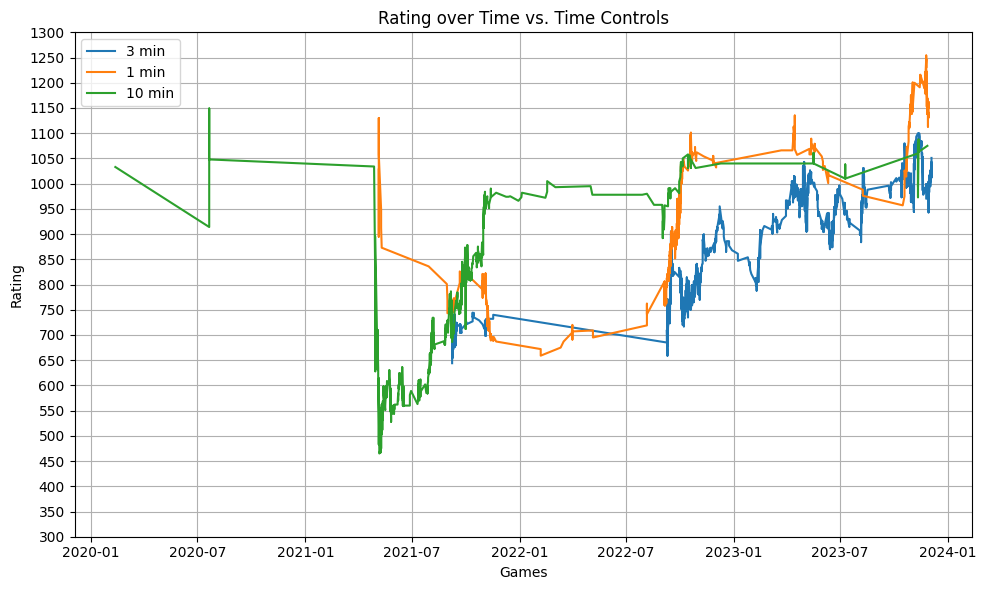

In [5]:
# Filter data for different time controls
df_3_min = df[df['Time Control'] == '3 min']
df_1_min = df[df['Time Control'] == '1 min']
df_10_min = df[df['Time Control'] == '10 min']

# sort dataframes by date
df_3_min = df_3_min.sort_values(by=['Date'])
df_1_min = df_1_min.sort_values(by=['Date'])
df_10_min = df_10_min.sort_values(by=['Date'])

# Get my rating for each game
def get_rating(row):
    if row['White'] == username:
        return row['White Rating']
    else:
        return row['Black Rating']

# apply function to each dataframe to get my rating for each game
df_3_min['Rating'] = df_3_min.apply(get_rating, axis=1)
df_1_min['Rating'] = df_1_min.apply(get_rating, axis=1)
df_10_min['Rating'] = df_10_min.apply(get_rating, axis=1)

# convert rating to numeric... this being an object caused me many minutes of pain
df_3_min['Rating'] = pd.to_numeric(df_3_min['Rating'], errors='coerce')
df_1_min['Rating'] = pd.to_numeric(df_1_min['Rating'], errors='coerce')
df_10_min['Rating'] = pd.to_numeric(df_10_min['Rating'], errors='coerce')


# Plotting ratings for each time control
plt.figure(figsize=(10, 6))

# plot each time control
plt.plot(df_3_min['Date'], df_3_min['Rating'], label='3 min')
plt.plot(df_1_min['Date'], df_1_min['Rating'], label='1 min')
plt.plot(df_10_min['Date'], df_10_min['Rating'], label='10 min')

plt.xlabel('Games')
plt.ylabel('Rating')
plt.title('Rating over Time vs. Time Controls')
plt.legend()
plt.grid(True)

# make the graph look nice
plt.ylim(300, 1300)

# unmess the yticks
y_ticks = list(range(300, 1301, 50))
plt.yticks(y_ticks, y_ticks)

plt.tight_layout()

plt.show()

Ok so generally, I'm improving, but I still suck. 

Let's answer these questions:
- What day did I play the most games?
- What day did I win the most games?
- What day did I lose the most games?
- What country do I play the most games against?

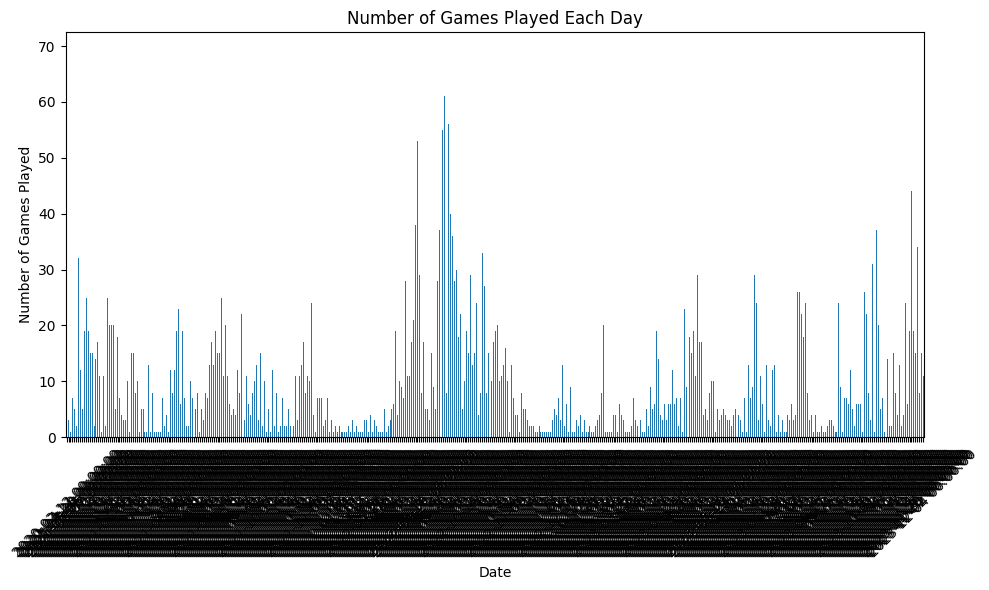

2022-09-28 00:00:00


69

In [6]:
# groupby to get number of games played each day
games_per_day = df.groupby('Date').size()

# plot the data
plt.figure(figsize=(10, 6))

games_per_day.plot(kind='bar')

plt.xlabel('Date')
plt.ylabel('Number of Games Played')
plt.title('Number of Games Played Each Day')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(games_per_day.idxmax())
games_per_day.max() # 69 games in one day, September 28, 2022

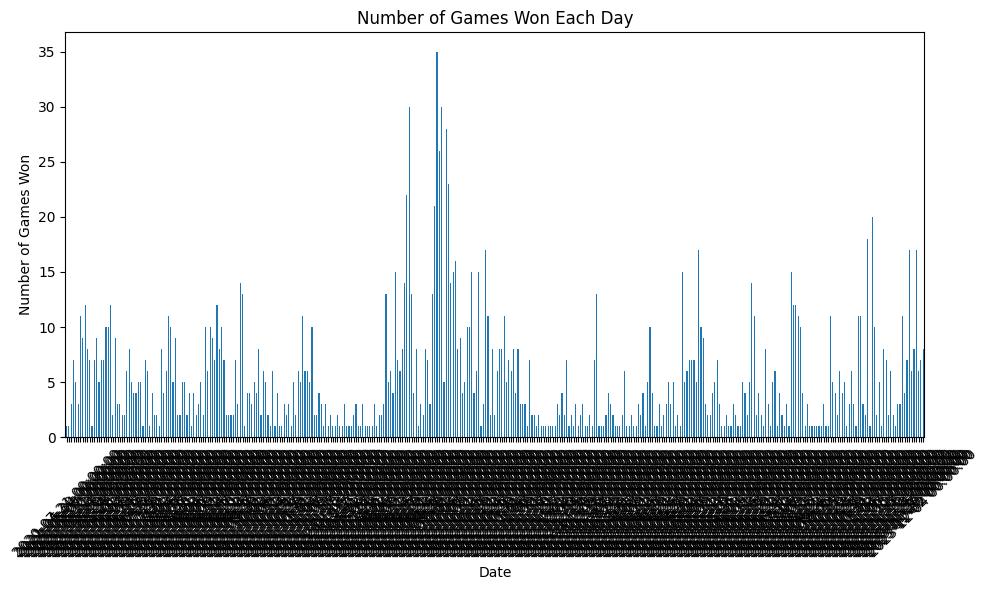

2022-09-28 00:00:00


35

In [7]:
# plot number of wins per day
wins_per_day = df[df['Did Jerry Win?'] == 'Win'].groupby('Date').size()

plt.figure(figsize=(10, 6))

wins_per_day.plot(kind='bar')

plt.xlabel('Date')
plt.ylabel('Number of Games Won')
plt.title('Number of Games Won Each Day')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(wins_per_day.idxmax())
wins_per_day.max() # 35 wins in one day, September 28, 2022

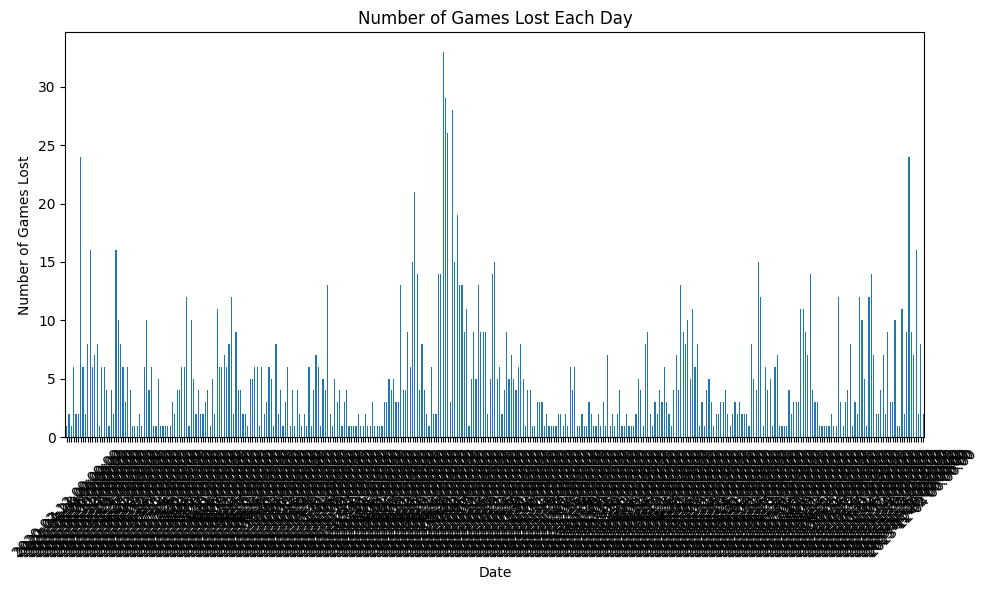

2022-09-28 00:00:00


33

In [8]:
# plot number of losses per day
losses_per_day = df[df['Did Jerry Win?'] == 'Loss'].groupby('Date').size()

plt.figure(figsize=(10, 6))

losses_per_day.plot(kind='bar')

plt.xlabel('Date')
plt.ylabel('Number of Games Lost')
plt.title('Number of Games Lost Each Day')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(losses_per_day.idxmax())
losses_per_day.max() # 33 losses in one day, September 28, 2022

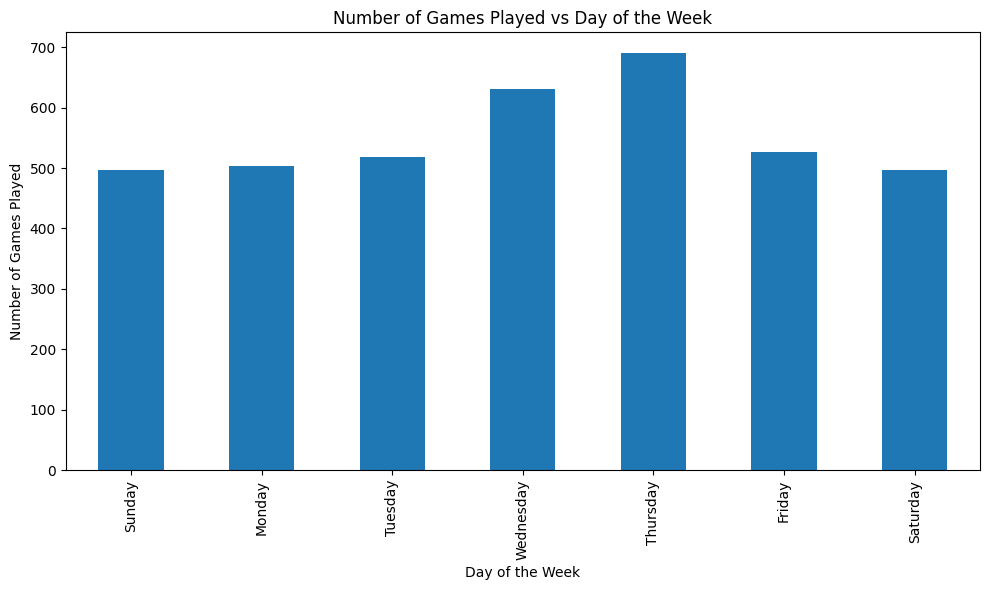

In [9]:
# what day of the week did I play the most games?

# get the day of the week using datetime (i love datetime)
df['Day_of_Week'] = df['Date'].dt.day_name()

# groupby it
games_per_day_of_week = df.groupby('Day_of_Week').size()

# reorder the data ... https://stackoverflow.com/questions/47741400/pandas-dataframe-group-and-sort-by-weekday
order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
games_per_day_of_week = games_per_day_of_week.reindex(order)

# plot it
plt.figure(figsize=(10, 6))

games_per_day_of_week.plot(kind='bar')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Games Played')
plt.title('Number of Games Played vs Day of the Week')

plt.tight_layout()
plt.show() # I played the most games on Thursdays, then Wednesdays

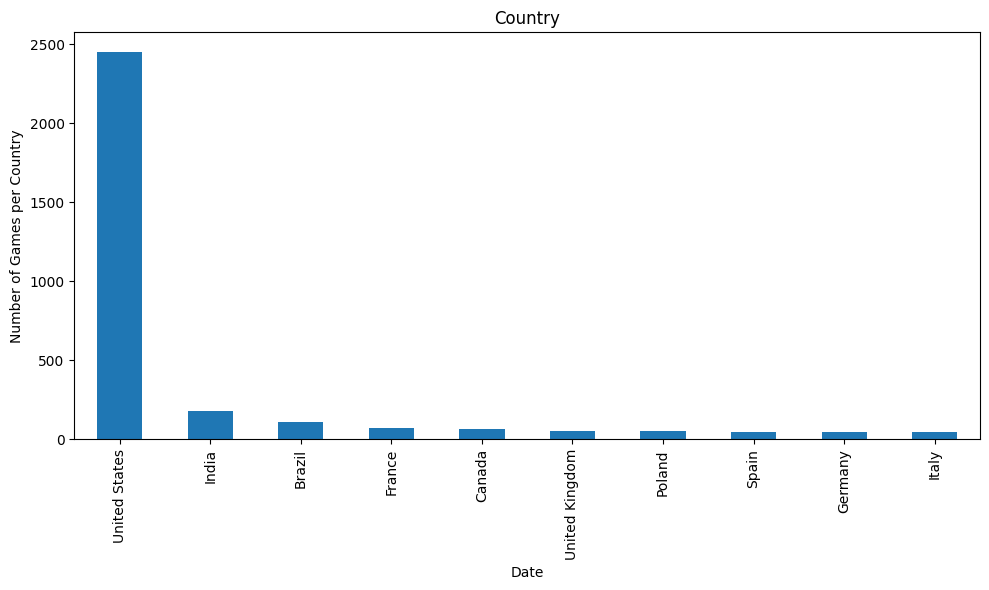

United States


2453

In [10]:
# what country do i play against the most?
countries = df.groupby('Black Country').size().sort_values(ascending=False) if df['White'].iloc[0] == username else df.groupby('White Country').size().sort_values(ascending=False)

top_countries = countries.head(10)

plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar')

plt.xlabel('Date')
plt.ylabel('Number of Games per Country')
plt.title('Country')

plt.tight_layout()
plt.show()

print(countries.idxmax())
countries.max() # USA, 2388 games

I wasn't suprised to see that I played the most games against other US players, especially since Chess.com is English-based and timezones and stuff.

I was suprised to see that I played 69 games on September 28th, 2022. Wow. Also really suprised to see that I play most games on Thursdays and Wednesdays. I thought I'd be a little more evenly spread out.

Ok, but why do I suck at chess and what can I do to improve? Let's answer these questions:
- What's my Win/Loss/Draw rate?
- What's my Wins by Color rate?
- What area of my game do I struggle with the most (opening, middlegame, endgame, where do I lose)?
- What is my accuracy against different levels of opponents?
- What is the correlation between my win rate and my accuracy? Rating? Opponent accuracy? Black/White?

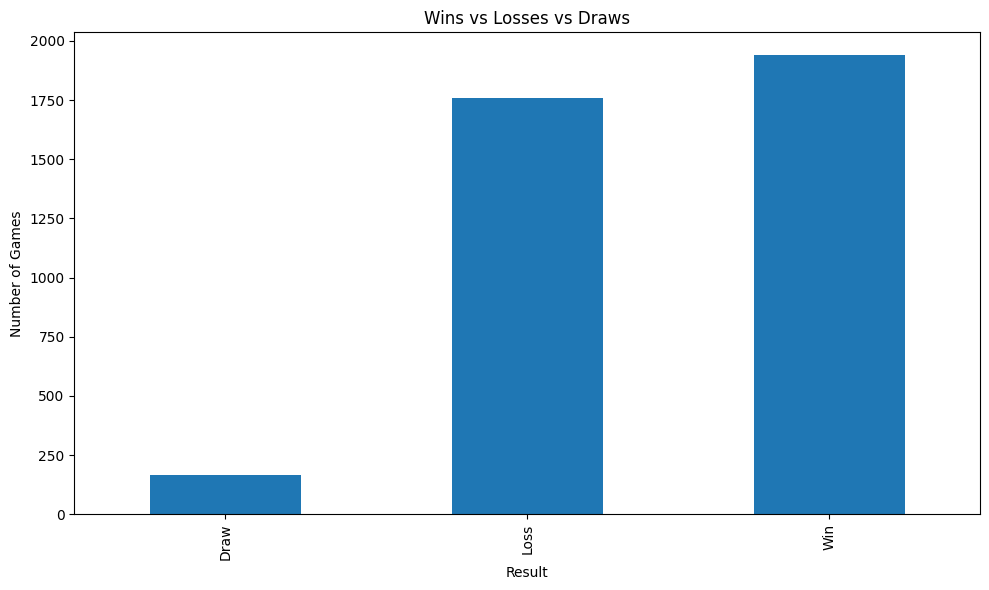

In [11]:
# let's begin with a simple visualization- Wins vs Losses vs Draws
# groupby the results
results = df.groupby('Did Jerry Win?').size()

# plot it
plt.figure(figsize=(10, 6))

results.plot(kind='bar')

plt.xlabel('Result')
plt.ylabel('Number of Games')
plt.title('Wins vs Losses vs Draws')

plt.tight_layout()
plt.show() # I've won slightly more games than I've lost... that's good, right?

<Figure size 1000x600 with 0 Axes>

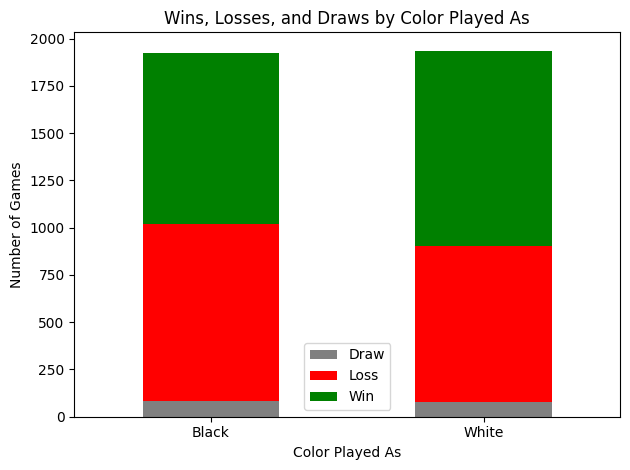

In [12]:
# win vs loss by color
# create a new column for color played
df['Color_Played'] = df.apply(lambda x: 'White' if x['White'] == 'Dizzyscar' else 'Black', axis=1)

# count the results
results = df.groupby(['Color_Played', 'Did Jerry Win?']).size().unstack().fillna(0)

# plot it
plt.figure(figsize=(10, 6))

results.plot(kind='bar', stacked=True, color=['gray', 'red', 'green'])
plt.xlabel('Color Played As')
plt.ylabel('Number of Games')
plt.title('Wins, Losses, and Draws by Color Played As')
plt.xticks(rotation=0)
plt.legend(['Draw', 'Loss', 'Win'])

plt.tight_layout()
plt.show() # I need to work on my black game... and my white game

C:\Users\Jerry\AppData\Local\Temp\ipykernel_31876\4167604002.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses_df['Moves'] = pd.to_numeric(losses_df['Moves'], errors='coerce')
C:\Users\Jerry\AppData\Local\Temp\ipykernel_31876\4167604002.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses_df['MoveCategory'] = pd.cut(losses_df['Moves'], bins=[0, 12, 50, float('inf')], labels=['Opening', 'Middlegame', 'Endgame'])


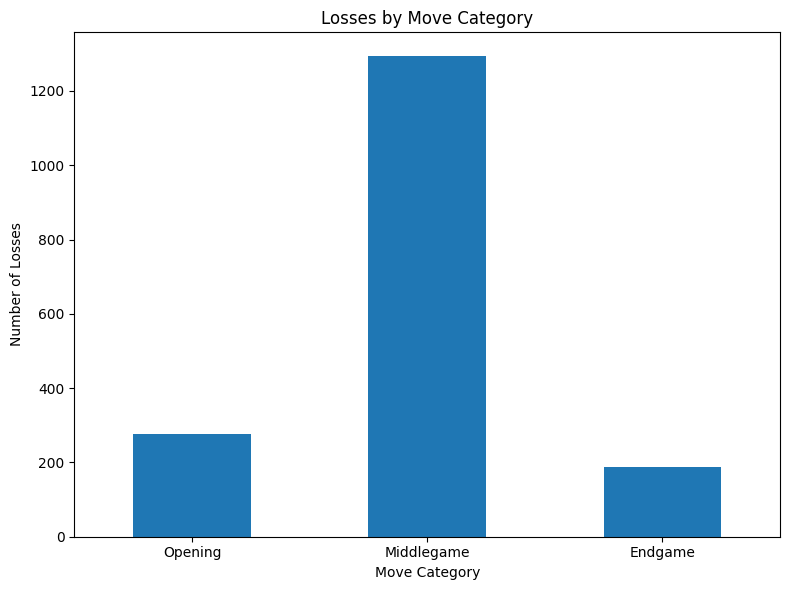

In [13]:
# what part of the game do I lose the most?

# filter for losses
losses_df = df[df['Did Jerry Win?'] == 'Loss']

# convert moves to numeric
losses_df['Moves'] = pd.to_numeric(losses_df['Moves'], errors='coerce')

# categorize losses by game phase... had to geeksforgeeks this one
losses_df['MoveCategory'] = pd.cut(losses_df['Moves'], bins=[0, 12, 50, float('inf')], labels=['Opening', 'Middlegame', 'Endgame'])

# count the losses .. and this one
losses_by_move_category = losses_df['MoveCategory'].value_counts().reindex(['Opening', 'Middlegame', 'Endgame']).fillna(0)

# plot it
plt.figure(figsize=(8, 6))

losses_by_move_category.plot(kind='bar')
plt.xlabel('Move Category')
plt.ylabel('Number of Losses')
plt.title('Losses by Move Category')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show() # I lose the most in the middlegame, but that might skew the endgame because I don't get to the endgame as often... either way i gotta stop blundering my queen

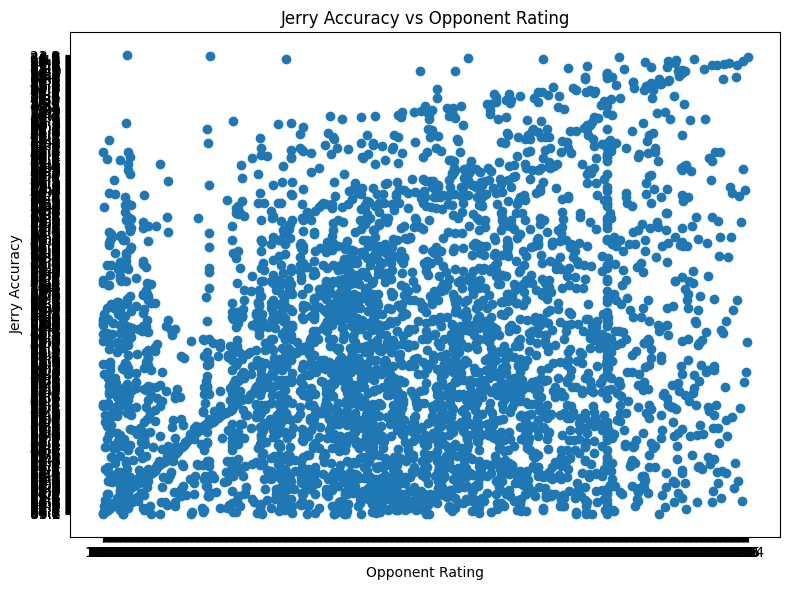

0.10824052413014218

In [15]:
# calculate opponent rating
df['Opponent Rating'] = df.apply(lambda x: x['Black Rating'] if x['White'] == username else x['White Rating'], axis=1)

# plot it
plt.figure(figsize=(8, 6))

plt.scatter(df['Opponent Rating'], df['Jerry Accuracy'])
plt.xlabel('Opponent Rating')
plt.ylabel('Jerry Accuracy')
plt.title('Jerry Accuracy vs Opponent Rating')

plt.tight_layout()
plt.show()

# calculate correlation
df['Jerry Accuracy'].corr(df['Opponent Rating']) # yea so barely some correlation... probably because I play against people with similar ratings to me

In [18]:
# convert result to numeric
df['Did Jerry Win numeric'] = df['Did Jerry Win?'].map({'Win': 1, 'Draw': 0, 'Loss': 0})

# calculate correlation
df['Did Jerry Win numeric'].corr(df['Jerry Accuracy']) # kinda surprising that there's not a stronger correlation

0.29785337484472957

In [21]:
# calculate opponent accuracy
df['Opponent Accuracy'] = df.apply(lambda x: x['Black Accuracy'] if x['White'] == username else x['White Accuracy'], axis=1)

# calc correlation
df['Did Jerry Win numeric'].corr(df['Opponent Accuracy']) # oooo some stronger correlation here

-0.3783792246285102

In [26]:
# now correlation between my rating and my accuracy

df_10_min['Rating'].corr(df_10_min['Jerry Accuracy']) # 0.26717690455252924
df_3_min['Rating'].corr(df_3_min['Jerry Accuracy']) # 0.11659486014394267
df_1_min['Rating'].corr(df_1_min['Jerry Accuracy']) # 0.08157487460877537

# doesn't suprise me... sometimes win/loss in lower time controls is just how fast you can move your mouse

0.08157487460877537

In [31]:
# now correlation between my accuracy and whether I play as white or black

black_df = df[df['Color_Played'] == 'Black']
white_df = df[df['Color_Played'] == 'White']

black_df['Jerry Accuracy'].corr(black_df['Did Jerry Win numeric']) # 0.24491995841675535
white_df['Jerry Accuracy'].corr(white_df['Did Jerry Win numeric']) # 0.3454608998979448

# I'm better as white... doesn't suprise me as I won more games as white

0.3454608998979448

After careful data collection and analysis, I've determined that to improve at Chess, I need to work on:
- Playing as Black
- Not blundering in the Middlegame
- Playing/studying consistently

I had a lot of fun with this project, and not only did I learn more about web scraping and data analysis, but I used it to identify my weaknesses and improve my chess game. I'm excited to not only use this data to improve my chess skills, but also using data analysis in many other applications.

In [33]:
# don't mind me, just a quick export to csv (hey that rhymes)
df.to_csv('chess.csv', index=False)